In [163]:
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import numpy as np
import pandas as pd
import xarray as xr
import itertools as it
import datetime
import scipy.stats as stats
from scipy.io import loadmat
from scipy.interpolate import CubicSpline, interp1d
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle
from scipy.stats import pearsonr
def convert_datetime(dt):
  return pd.to_datetime(dt - 719529, unit='D').round('min')

In [164]:
data = np.load('./sfbay_sediment.npy', allow_pickle=True).item()
n_points = len(data['tstart'])

In [165]:
full_df = pd.DataFrame(index=list(range(n_points)), columns=list(data.keys()), dtype=object)
for key, dat in data.items():
  if dat.shape == (n_points,):
    full_df[key] = dat
  else:
    for i in range(n_points):
      full_df.at[i, key] = dat[i,:]

In [166]:
cols_to_extract = [key for key, dat in data.items() if dat.shape == (n_points,)]
cols_to_drop = ['cw5', 'depth', 'apg9', 'cpg9', 'npreal', 'chl45', 'ssc5', 'ubar15', 'ubar45', 'vbar15', 'vbar45']
# cols_to_drop = []
cols_to_extract = [k for k in cols_to_extract if k not in cols_to_drop]
df = full_df[cols_to_extract].copy()
df['tstart'] = convert_datetime(df['tstart'])
df.sort_values('tstart', inplace=True)

n_shifts = 12
tau = 1
for i in range(n_shifts):
  df[f'ubar5_delayed_{i+1}'] = df['ubar5'].shift(tau*(i+1))
df.dropna(inplace=True)

In [167]:
# Define the feature matrix X and the target vector y
feature_labels = [k for k in cols_to_extract if ('dmean' not in k) and ('tstart' not in k)]
target_labels = [k for k in cols_to_extract if 'dmean' in k]
X = df[feature_labels]
y = df[target_labels]

In [168]:
# Define all hyper-parameters
test_size = 0.2
seed = 42
layer_sizes = [X.shape[1], 10, y.shape[1]]
l1, l2 = 0.01, 0.01
activation = 'relu'
n_epochs = 1000
val_split = 0.2

In [169]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# Standardize the features
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
Y_scaler = StandardScaler()
y_train = Y_scaler.fit_transform(y_train)
y_test = Y_scaler.transform(y_test)

## Sequential neural net model:

In [170]:
def create_sequential_model(layer_sizes: list, l1: float, l2: float, activation: str) -> Sequential:
  # Initialize a sequential model
  model = Sequential()
  regularizer = L1L2(l1, l2)
  n_layers = len(layer_sizes)
  for j in range(1, n_layers-1):
    input_sz = layer_sizes[j-1]
    output_sz = layer_sizes[j]
    model.add(Dense(units=output_sz, input_dim=input_sz, kernel_regularizer=regularizer, activation=activation))
  model.add(Dense(units=layer_sizes[-1], input_dim=layer_sizes[-2], activation='linear'))
  return model

def plot_training_curves(history) -> plt.Axes:
  # plot how the accuracy on the training and validation datasets evolved during training
  ax = plt.subplot()
  ax.plot(history.history['loss'],label='Training')
  ax.plot(history.history['val_loss'],label='Validation')
  ax.legend()
  ax.set_ylim([0,1])
  ax.set_title('Training and Validation Loss')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  return ax

In [171]:
model = create_sequential_model(layer_sizes, l1, l2, activation)
# Compile the model with mean squared error loss and an optimizer
model.compile(optimizer='adam', loss='mse')
model.summary()

/Users/andrewwatford/anaconda3/envs/dso_uw/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 10)             │           290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312 (1.22 KB)

 Trainable params: 312 (1.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.4732 - val_loss: 2.0112
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2289 - val_loss: 1.7662
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8714 - val_loss: 1.5976
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7774 - val_loss: 1.4791
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6855 - val_loss: 1.4016
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5666 - val_loss: 1.3376
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4980 - val_loss: 1.2868
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4860 - val_loss: 1.2477
Epoch 9/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3168 - val_loss: 1.2113
Epoch 10/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3069 - val_loss: 1.1753
Epoch 11/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2560 - val_loss: 1.1466
Epoch 12/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/ste

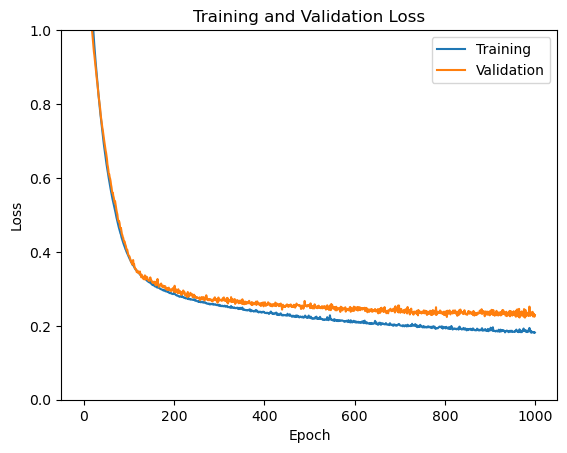

In [172]:
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=val_split, verbose=1)
ax = plot_training_curves(history)
plt.show()

In [173]:
# Evaluate
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
# Evaluate
y_pred = model.predict(X_test)
y_test_original, y_pred_original = Y_scaler.inverse_transform(y_test), Y_scaler.inverse_transform(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2898 
Loss: 0.27509576082229614
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


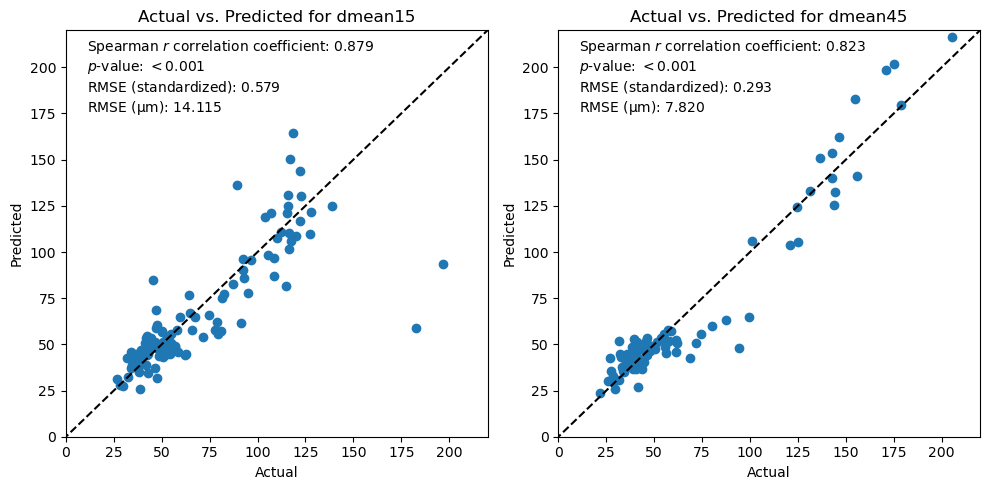

In [174]:
# Compare predictions with the actual values
fig, axs = plt.subplots(1,2, figsize=(10,5))
for nf in range(y.shape[1]):
  scorer = tf.keras.metrics.RootMeanSquaredError()
  scorer.update_state(y_test[:,nf], y_pred[:,nf])
  rmse_s = scorer.result().numpy()
  scorer.update_state(y_test_original[:,nf], y_pred_original[:,nf])
  rmse_o = scorer.result().numpy()

  scatter_ax = axs[nf]
  # Scatter plot
  scatter_ax.scatter(y_test_original[:,nf], y_pred_original[:,nf])
  scatter_ax.set_xlim([0,220])
  scatter_ax.set_ylim([0,220])
  scatter_ax.plot([-10,220],[-10,220], 'k--')
  scatter_ax.set_xlabel('Actual')
  scatter_ax.set_ylabel('Predicted')
  scatter_ax.set_title(f'Actual vs. Predicted for {target_labels[nf]}')
  sr = stats.spearmanr(y_test_original[:,nf], y_pred_original[:,nf])
  sr_text = f'Spearman $r$ correlation coefficient: ${sr.statistic.round(3)}$'
  p_text = f'$p$-value: ${sr.pvalue:.3f}$'  if sr.pvalue > 0.001 else f'$p$-value: $<0.001$'
  rmse_s_text = f'RMSE (standardized): ${rmse_s:.3f}$'
  rmse_o_text = f'RMSE (μm): ${rmse_o:.3f}$'

  y_test_original, y_pred_original = Y_scaler.inverse_transform(y_test), Y_scaler.inverse_transform(y_pred)
  scatter_ax.annotate(sr_text, xy=(0.05, 0.95), xycoords='axes fraction')
  scatter_ax.annotate(p_text, xy=(0.05, 0.90), xycoords='axes fraction')
  scatter_ax.annotate(rmse_s_text, xy=(0.05, 0.85), xycoords='axes fraction')
  scatter_ax.annotate(rmse_o_text, xy=(0.05, 0.8), xycoords='axes fraction')
fig.tight_layout();

## Compare this to a linear regression / model:

In [175]:
model = create_sequential_model([X.shape[1], y.shape[1]], 0, 0, 'linear')
model.compile(optimizer='adam', loss='mse')
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=100, validation_split=val_split, verbose=0)

/Users/andrewwatford/anaconda3/envs/dso_uw/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [176]:
# Evaluate
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
# Evaluate
y_pred = model.predict(X_test)
y_test_original, y_pred_original = Y_scaler.inverse_transform(y_test), Y_scaler.inverse_transform(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3577 
Loss: 0.32372528314590454
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


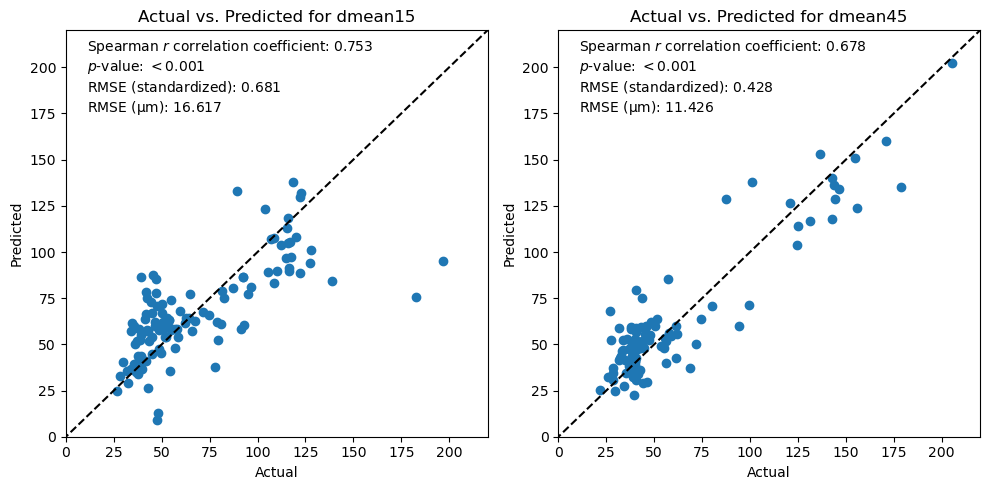

In [177]:
# Compare predictions with the actual values
fig, axs = plt.subplots(1,2, figsize=(10,5))
for nf in range(y.shape[1]):
  scorer = tf.keras.metrics.RootMeanSquaredError()
  scorer.update_state(y_test[:,nf], y_pred[:,nf])
  rmse_s = scorer.result().numpy()
  scorer.update_state(y_test_original[:,nf], y_pred_original[:,nf])
  rmse_o = scorer.result().numpy()

  scatter_ax = axs[nf]
  # Scatter plot
  scatter_ax.scatter(y_test_original[:,nf], y_pred_original[:,nf])
  scatter_ax.set_xlim([0,220])
  scatter_ax.set_ylim([0,220])
  scatter_ax.plot([-10,220],[-10,220], 'k--')
  scatter_ax.set_xlabel('Actual')
  scatter_ax.set_ylabel('Predicted')
  scatter_ax.set_title(f'Actual vs. Predicted for {target_labels[nf]}')
  sr = stats.spearmanr(y_test_original[:,nf], y_pred_original[:,nf])
  sr_text = f'Spearman $r$ correlation coefficient: ${sr.statistic.round(3)}$'
  p_text = f'$p$-value: ${sr.pvalue:.3f}$'  if sr.pvalue > 0.001 else f'$p$-value: $<0.001$'
  rmse_s_text = f'RMSE (standardized): ${rmse_s:.3f}$'
  rmse_o_text = f'RMSE (μm): ${rmse_o:.3f}$'

  y_test_original, y_pred_original = Y_scaler.inverse_transform(y_test), Y_scaler.inverse_transform(y_pred)
  scatter_ax.annotate(sr_text, xy=(0.05, 0.95), xycoords='axes fraction')
  scatter_ax.annotate(p_text, xy=(0.05, 0.90), xycoords='axes fraction')
  scatter_ax.annotate(rmse_s_text, xy=(0.05, 0.85), xycoords='axes fraction')
  scatter_ax.annotate(rmse_o_text, xy=(0.05, 0.8), xycoords='axes fraction')
fig.tight_layout();